# Importing packages

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Installing UGent Panno font

Before running there are a few steps that need to be taken.

Download this: https://www.ugent.be/intranet/nl/op-het-werk/communicatie/huisstijl-presentaties/huisstijl/panno-text.zip
Unzip 'panno-text.zip'

Open and unzip '150831-ugentpannotext-v300-truetype.zip'

Upload the 'UGentPannoText-Normal' to this drive in the local directory!!!! (on the left bar, click the folder-icon, upload the 'UGentPannoText-Normal')

In [ ]:
#!mv UGentPannoText-Normal.ttf /usr/share/fonts/truetype/
font_files = fm.findSystemFonts('.')

for font_file in font_files:
    fm.fontManager.addfont(font_file)
print(font_files)
plt.rc('font', family='UGent Panno Text')
#path = '/usr/share/fonts/truetype/UGentPannoText-Normal.ttf'
#fontprop = fm.FontProperties(fname=path)

['/content/UGentPannoText-SemiBold.ttf', '/content/UGentPannoText-Normal.ttf', '/content/UGentPannoText-Medium.ttf', '/content/UGentPannoText-SemiLight.ttf']


# Defining plot layout

In [ ]:
plt.style.use('bmh')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Model definition

In [ ]:
def FCNK(kmer, tax, epochsize):
    print(f'Initiating training, validation and testing on {tax} level with {kmer}.')

    class mydataset(Dataset):
        def __init__(self, x, y):
            self.x = torch.tensor(x, dtype=torch.float32, device='cpu')
            self.y = torch.tensor(y, dtype=torch.long, device='cpu')
            self.length = self.x.shape[0]

        def __getitem__(self, idx):
            return self.x[idx], self.y[idx]

        def __len__(self):
            return self.length

    class Net(nn.Module):
        def __init__(self, input_shape, output_shape, shape1, shape2):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(input_shape, shape1)
            self.fc2 = nn.Linear(shape1, shape2)
            self.fcout = nn.Linear(shape2, output_shape)
            self.relu = nn.ReLU()

        def forward(self, x):
            out = self.fc1(x)
            out = self.relu(out)

            out = self.fc2(out)
            out = self.relu(out)

            out = self.fcout(out)
            return out

    # Load the existed Training & Validation & Testing Dataset
    base_path = '/content/drive/MyDrive/BachelorsProject/FinalModels/1NOAMBI/'
    
    # These files are all in my google drive
    TrainX = np.load(f'{base_path}Train_X_{kmer}1NA.npy')
    TrainY = np.load(f'{base_path}Train_Y_{tax}1NA.npy')
    TestX = np.load(f'{base_path}Test_X_{kmer}1NA.npy')
    TestY = np.load(f'{base_path}Test_Y_{tax}1NA.npy')
    ValX = np.load(f'{base_path}Validation_X_{kmer}1NA.npy')
    ValY = np.load(f'{base_path}Validation_Y_{tax}1NA.npy')
    print('Training, test and validation datasets are loaded...')

    batches = 100
    trainset = mydataset(TrainX, TrainY)
    valset = mydataset(ValX, ValY)
    testset = mydataset(TestX, TestY)
    trainloader = DataLoader(trainset, batch_size=batches, shuffle=True)
    valloader = DataLoader(valset, batch_size=batches, shuffle=False)
    testloader = DataLoader(testset, batch_size=batches, shuffle=False)
    print('Loading trainset, trainloader, testset, testloader ...')

    learning_rate = 0.001
    epochs = epochsize
    input_size = TrainX.shape[1]
    size1 = TrainX.shape[1] * 3 // 4
    size2 = TrainX.shape[1] * 1 // 4
    output_size = len(np.unique(TrainY))
    model = Net(input_shape=input_size, output_shape=output_size, shape1= size1, shape2= size2)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    print('Setting hyperparameters...')

    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    print('Training model...')
    for epoch in range(epochs):
        # Training loop
        model.train()
        training_loss = 0.0
        correct = 0
        total = 0
        for j, (x_train, y_train) in enumerate(trainloader):
            # calculate output
            output = model(x_train)

            # calculate loss
            loss = loss_fn(output, y_train)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss and accuracy
            training_loss += loss.item() * x_train.size(0)
            output_tags = torch.argmax(output, dim=1)
            targets = y_train
            correct += (output_tags == targets).sum().item()
            total += y_train.size(0)

        # Print training statistics
        epoch_loss = training_loss / len(trainloader.dataset)
        epoch_acc = 100. * correct / total
        print(f'Epoch [{epoch + 1}] Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')

        # Store the training loss and training accuracy
        training_losses.append(epoch_loss)
        training_accuracies.append(epoch_acc)

        # Validation loop
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for j, (x_val, y_val) in enumerate(valloader):
                output = model(x_val)
                loss = loss_fn(output, y_val)
                # Calculate validation loss and accuracy
                validation_loss += loss.item() * x_val.size(0)
                output_tags = torch.argmax(output, dim=1)
                targets = y_val
                correct += (output_tags == targets).sum().item()
                total += y_val.size(0)

        # Print validation statistics
        epoch_val_loss = validation_loss / len(valloader.dataset)
        epoch_val_acc = 100. * correct / total
        print(f'Epoch [{epoch + 1}] Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.2f}%')

        # Store the validation loss and validation accuracy
        validation_losses.append(epoch_val_loss)
        validation_accuracies.append(epoch_val_acc)

    # Testing
    with torch.no_grad():
        y_pred = []
        y_true = []
        # simple accuracy as above
        for x_test, y_test in testloader:
            test_output = model(x_test)
            y_pred += torch.argmax(test_output, dim=1).tolist()
            y_true += y_test.tolist()
        report_dict = metrics.classification_report(y_true, y_pred, digits=3)
        print(report_dict)


    plt.plot(training_losses, label='Training', color='#1E64C8', linewidth=1)
    plt.plot(validation_losses, label='Validation', color='black', linewidth=1)
    plt.title(f'Training and Validation Loss of the FCN on {tax} level with {kmer}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (in %)')
    plt.legend()
    plt.savefig(f'FCNK{tax}{kmer}Loss1NA.svg')
    files.download(f'FCNK{tax}{kmer}Loss1NA.svg') 
    plt.show()

    plt.plot(training_accuracies, label='Training', color='#1E64C8', linewidth=1)
    plt.plot(validation_accuracies, label='Validation', color='black', linewidth=1)
    plt.title(f'Training and Validation Accuracy of the FCN on {tax} level with {kmer}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (in %)')
    plt.legend()
    plt.savefig(f'FCNK{tax}{kmer}Accuracy1NA.svg')
    files.download(f'FCNK{tax}{kmer}Accuracy1NA.svg') 
    plt.show()
    print(f'Training, validation and testing on {tax} level with {kmer} is completed.')

# 3mer

Initiating training, validation and testing on PHYLUM level with 3mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 1.0631, Training Accuracy: 54.93%
Epoch [1] Validation Loss: 0.9245, Validation Accuracy: 55.87%
Epoch [2] Training Loss: 0.5662, Training Accuracy: 79.15%
Epoch [2] Validation Loss: 0.3281, Validation Accuracy: 87.96%
Epoch [3] Training Loss: 0.2780, Training Accuracy: 90.76%
Epoch [3] Validation Loss: 0.2470, Validation Accuracy: 93.09%
Epoch [4] Training Loss: 0.2288, Training Accuracy: 93.38%
Epoch [4] Validation Loss: 0.2104, Validation Accuracy: 93.64%
Epoch [5] Training Loss: 0.1988, Training Accuracy: 93.71%
Epoch [5] Validation Loss: 0.1839, Validation Accuracy: 93.90%
Epoch [6] Training Loss: 0.1754, Training Accuracy: 94.04%
Epoch [6] Validation Loss: 0.1635, Validation Accuracy: 94.34%
Epoch [7] Training Loss: 0.1575, Training Ac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

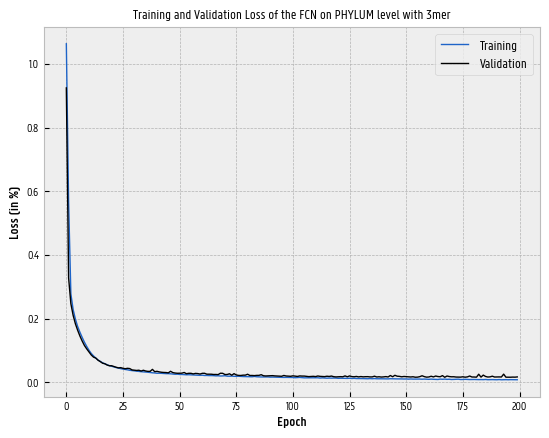

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

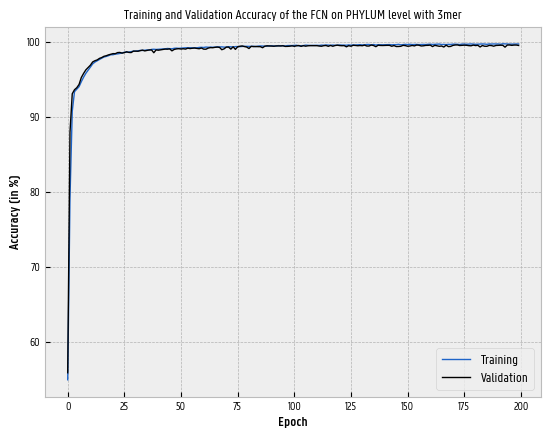

Training, validation and testing on PHYLUM level with 3mer is completed.


In [ ]:
FCNK('3mer', 'PHYLUM', 200)

Initiating training, validation and testing on CLASS level with 3mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 1.8970, Training Accuracy: 50.66%
Epoch [1] Validation Loss: 1.6505, Validation Accuracy: 54.36%
Epoch [2] Training Loss: 1.4533, Training Accuracy: 56.38%
Epoch [2] Validation Loss: 1.2588, Validation Accuracy: 63.66%
Epoch [3] Training Loss: 1.0773, Training Accuracy: 66.59%
Epoch [3] Validation Loss: 0.9662, Validation Accuracy: 70.25%
Epoch [4] Training Loss: 0.8257, Training Accuracy: 76.29%
Epoch [4] Validation Loss: 0.7526, Validation Accuracy: 77.76%
Epoch [5] Training Loss: 0.6868, Training Accuracy: 79.57%
Epoch [5] Validation Loss: 0.6637, Validation Accuracy: 79.97%
Epoch [6] Training Loss: 0.6219, Training Accuracy: 81.27%
Epoch [6] Validation Loss: 0.6115, Validation Accuracy: 81.14%
Epoch [7] Training Loss: 0.5856, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

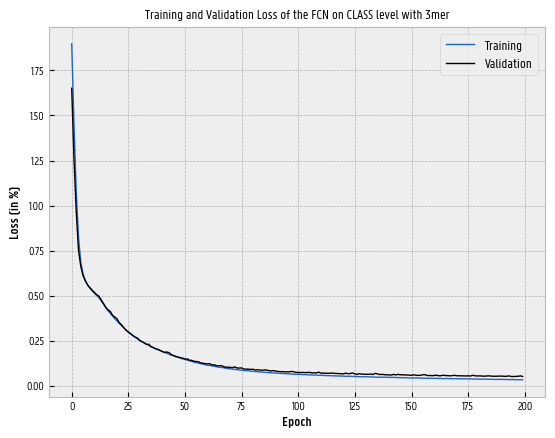

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

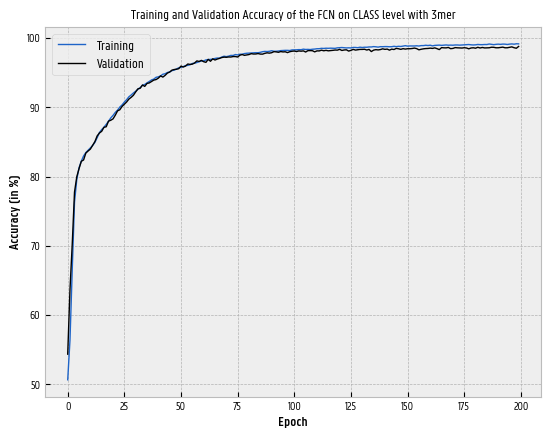

Training, validation and testing on CLASS level with 3mer is completed.


In [ ]:
FCNK('3mer', 'CLASS', 200)

Initiating training, validation and testing on ORDER level with 3mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 3.1912, Training Accuracy: 20.75%
Epoch [1] Validation Loss: 2.9164, Validation Accuracy: 24.55%
Epoch [2] Training Loss: 2.6787, Training Accuracy: 28.87%
Epoch [2] Validation Loss: 2.4378, Validation Accuracy: 33.52%
Epoch [3] Training Loss: 2.3103, Training Accuracy: 35.74%
Epoch [3] Validation Loss: 2.1950, Validation Accuracy: 37.53%
Epoch [4] Training Loss: 2.0929, Training Accuracy: 41.74%
Epoch [4] Validation Loss: 1.9442, Validation Accuracy: 49.05%
Epoch [5] Training Loss: 1.7905, Training Accuracy: 51.91%
Epoch [5] Validation Loss: 1.6556, Validation Accuracy: 55.41%
Epoch [6] Training Loss: 1.5903, Training Accuracy: 56.39%
Epoch [6] Validation Loss: 1.5172, Validation Accuracy: 58.88%
Epoch [7] Training Loss: 1.4795, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

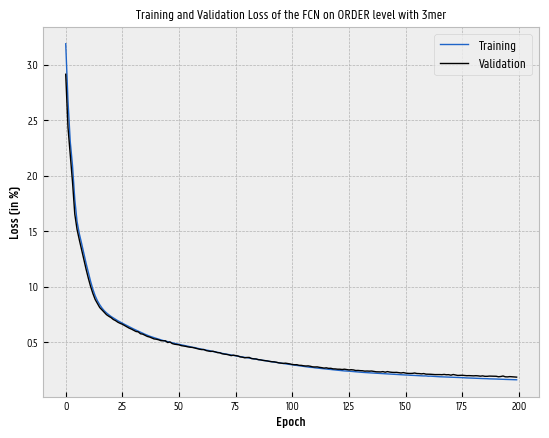

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

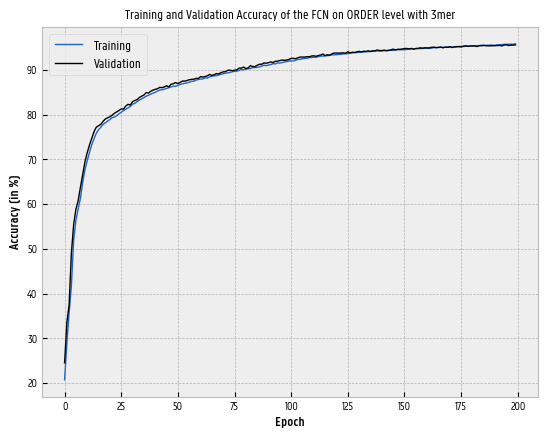

Training, validation and testing on ORDER level with 3mer is completed.


In [ ]:
FCNK('3mer', 'ORDER', 200)

Initiating training, validation and testing on FAMILY level with 3mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 4.2260, Training Accuracy: 9.34%
Epoch [1] Validation Loss: 4.0268, Validation Accuracy: 10.78%
Epoch [2] Training Loss: 3.9041, Training Accuracy: 12.13%
Epoch [2] Validation Loss: 3.7105, Validation Accuracy: 16.86%
Epoch [3] Training Loss: 3.5160, Training Accuracy: 18.22%
Epoch [3] Validation Loss: 3.2793, Validation Accuracy: 23.45%
Epoch [4] Training Loss: 3.0060, Training Accuracy: 32.06%
Epoch [4] Validation Loss: 2.6866, Validation Accuracy: 35.35%
Epoch [5] Training Loss: 2.5213, Training Accuracy: 37.79%
Epoch [5] Validation Loss: 2.3637, Validation Accuracy: 39.79%
Epoch [6] Training Loss: 2.2813, Training Accuracy: 42.25%
Epoch [6] Validation Loss: 2.1824, Validation Accuracy: 43.84%
Epoch [7] Training Loss: 2.1247, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

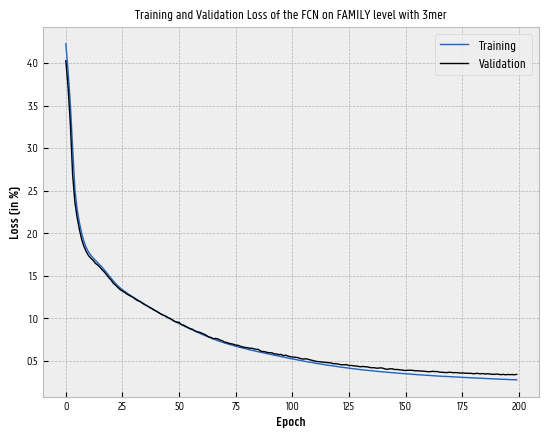

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

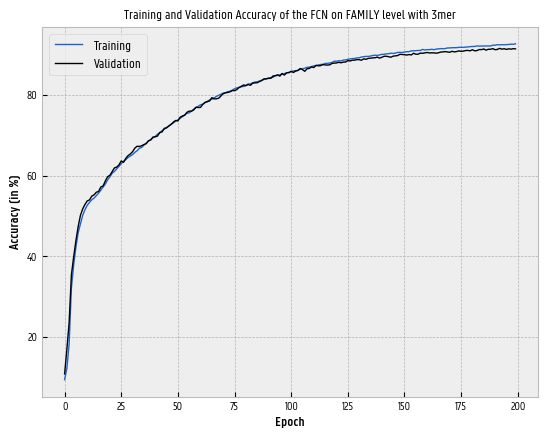

Training, validation and testing on FAMILY level with 3mer is completed.


In [ ]:
FCNK('3mer', 'FAMILY', 200)

Initiating training, validation and testing on GENUS level with 3mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 4.7288, Training Accuracy: 8.29%
Epoch [1] Validation Loss: 4.5245, Validation Accuracy: 10.13%
Epoch [2] Training Loss: 4.3837, Training Accuracy: 10.91%
Epoch [2] Validation Loss: 4.0968, Validation Accuracy: 14.42%
Epoch [3] Training Loss: 3.8652, Training Accuracy: 16.61%
Epoch [3] Validation Loss: 3.6441, Validation Accuracy: 22.23%
Epoch [4] Training Loss: 3.5133, Training Accuracy: 25.36%
Epoch [4] Validation Loss: 3.3250, Validation Accuracy: 29.44%
Epoch [5] Training Loss: 3.1553, Training Accuracy: 30.82%
Epoch [5] Validation Loss: 2.9897, Validation Accuracy: 32.36%
Epoch [6] Training Loss: 2.8981, Training Accuracy: 32.87%
Epoch [6] Validation Loss: 2.8038, Validation Accuracy: 33.25%
Epoch [7] Training Loss: 2.7444, Training Accu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

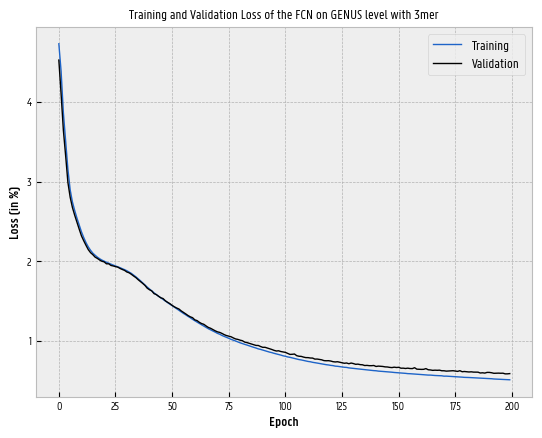

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

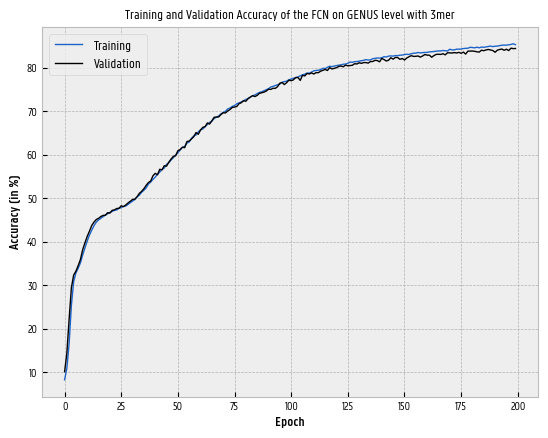

Training, validation and testing on GENUS level with 3mer is completed.


In [ ]:
FCNK('3mer', 'GENUS', 200)

# 4mer

Initiating training, validation and testing on PHYLUM level with 4mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 0.6146, Training Accuracy: 76.29%
Epoch [1] Validation Loss: 0.1353, Validation Accuracy: 95.35%
Epoch [2] Training Loss: 0.0777, Training Accuracy: 97.51%
Epoch [2] Validation Loss: 0.0437, Validation Accuracy: 98.73%
Epoch [3] Training Loss: 0.0320, Training Accuracy: 99.11%
Epoch [3] Validation Loss: 0.0276, Validation Accuracy: 99.17%
Epoch [4] Training Loss: 0.0195, Training Accuracy: 99.41%
Epoch [4] Validation Loss: 0.0210, Validation Accuracy: 99.42%
Epoch [5] Training Loss: 0.0134, Training Accuracy: 99.63%
Epoch [5] Validation Loss: 0.0134, Validation Accuracy: 99.71%
Epoch [6] Training Loss: 0.0103, Training Accuracy: 99.75%
Epoch [6] Validation Loss: 0.0124, Validation Accuracy: 99.60%
Epoch [7] Training Loss: 0.0084, Training Ac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

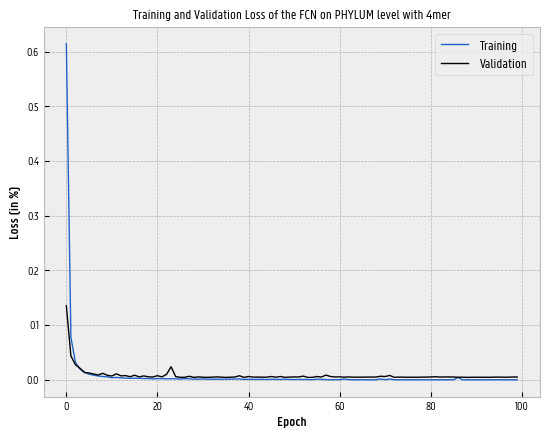

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

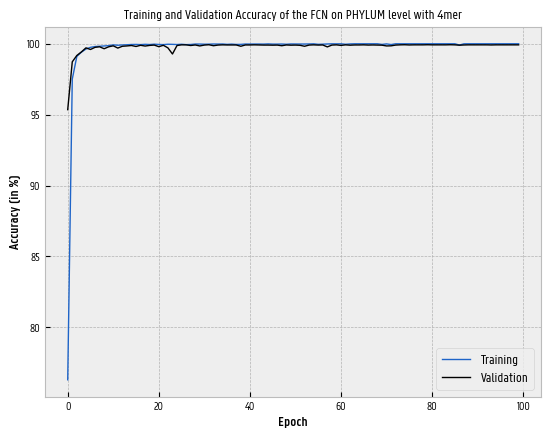

Training, validation and testing on PHYLUM level with 4mer is completed.


In [ ]:
FCNK('4mer', 'PHYLUM', 100)

Initiating training, validation and testing on CLASS level with 4mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 1.5295, Training Accuracy: 57.41%
Epoch [1] Validation Loss: 1.0401, Validation Accuracy: 65.40%
Epoch [2] Training Loss: 0.6655, Training Accuracy: 79.17%
Epoch [2] Validation Loss: 0.4676, Validation Accuracy: 85.52%
Epoch [3] Training Loss: 0.4054, Training Accuracy: 86.78%
Epoch [3] Validation Loss: 0.3974, Validation Accuracy: 86.87%
Epoch [4] Training Loss: 0.3462, Training Accuracy: 88.63%
Epoch [4] Validation Loss: 0.3461, Validation Accuracy: 89.00%
Epoch [5] Training Loss: 0.2999, Training Accuracy: 90.38%
Epoch [5] Validation Loss: 0.3002, Validation Accuracy: 91.01%
Epoch [6] Training Loss: 0.2569, Training Accuracy: 91.95%
Epoch [6] Validation Loss: 0.2578, Validation Accuracy: 92.30%
Epoch [7] Training Loss: 0.2123, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

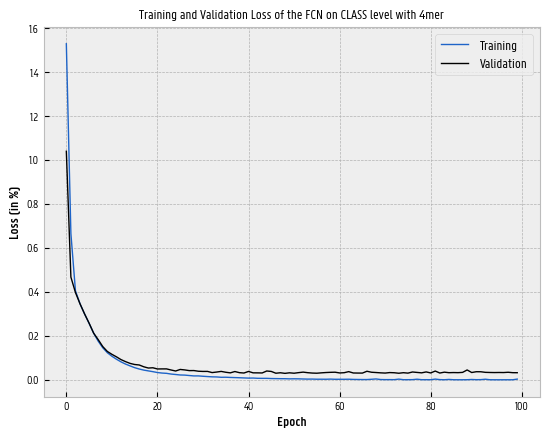

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

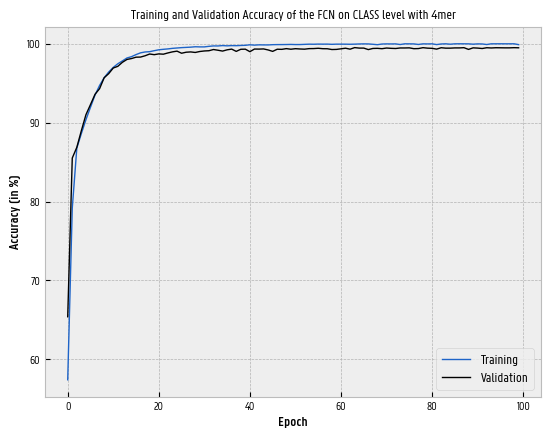

Training, validation and testing on CLASS level with 4mer is completed.


In [ ]:
FCNK('4mer', 'CLASS', 100)

Initiating training, validation and testing on ORDER level with 4mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 2.7780, Training Accuracy: 28.12%
Epoch [1] Validation Loss: 2.0663, Validation Accuracy: 47.73%
Epoch [2] Training Loss: 1.5333, Training Accuracy: 59.76%
Epoch [2] Validation Loss: 1.1723, Validation Accuracy: 71.03%
Epoch [3] Training Loss: 1.0095, Training Accuracy: 74.05%
Epoch [3] Validation Loss: 0.8687, Validation Accuracy: 76.75%
Epoch [4] Training Loss: 0.7906, Training Accuracy: 78.30%
Epoch [4] Validation Loss: 0.7411, Validation Accuracy: 79.85%
Epoch [5] Training Loss: 0.6509, Training Accuracy: 81.51%
Epoch [5] Validation Loss: 0.5898, Validation Accuracy: 83.05%
Epoch [6] Training Loss: 0.5404, Training Accuracy: 84.81%
Epoch [6] Validation Loss: 0.4974, Validation Accuracy: 86.60%
Epoch [7] Training Loss: 0.4502, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

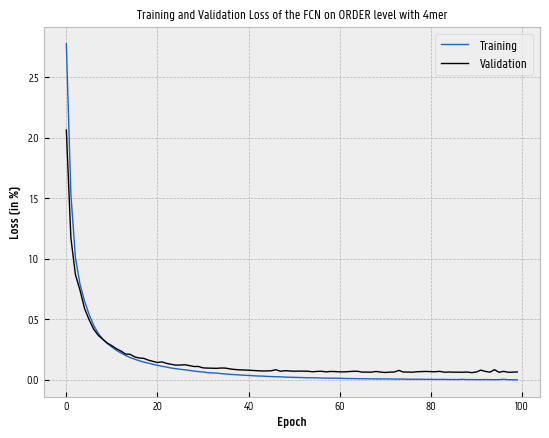

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

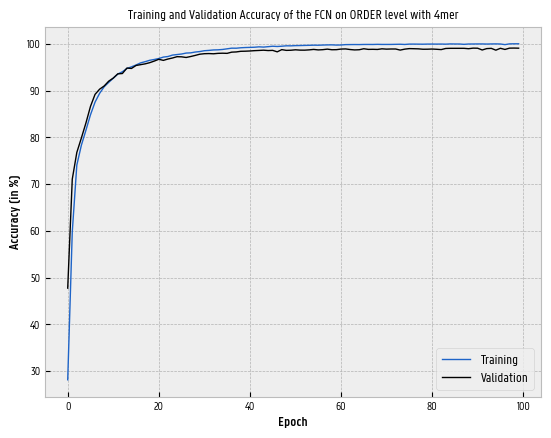

Training, validation and testing on ORDER level with 4mer is completed.


In [ ]:
FCNK('4mer', 'ORDER', 100)

Initiating training, validation and testing on FAMILY level with 4mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 3.9712, Training Accuracy: 11.47%
Epoch [1] Validation Loss: 3.3329, Validation Accuracy: 19.91%
Epoch [2] Training Loss: 2.8536, Training Accuracy: 32.07%
Epoch [2] Validation Loss: 2.3494, Validation Accuracy: 42.93%
Epoch [3] Training Loss: 2.0087, Training Accuracy: 49.19%
Epoch [3] Validation Loss: 1.7429, Validation Accuracy: 54.97%
Epoch [4] Training Loss: 1.6213, Training Accuracy: 56.73%
Epoch [4] Validation Loss: 1.5159, Validation Accuracy: 58.77%
Epoch [5] Training Loss: 1.4400, Training Accuracy: 60.22%
Epoch [5] Validation Loss: 1.3752, Validation Accuracy: 60.66%
Epoch [6] Training Loss: 1.3348, Training Accuracy: 62.41%
Epoch [6] Validation Loss: 1.2991, Validation Accuracy: 63.60%
Epoch [7] Training Loss: 1.2592, Training Ac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

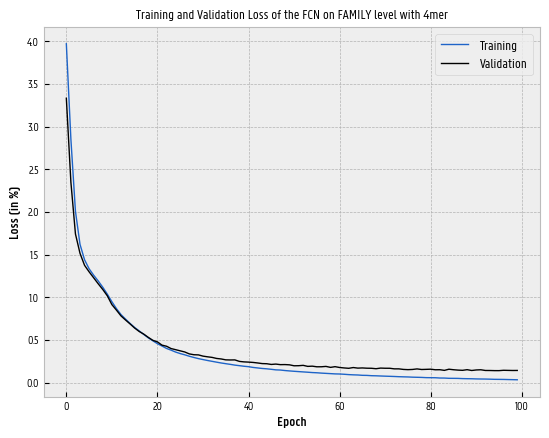

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

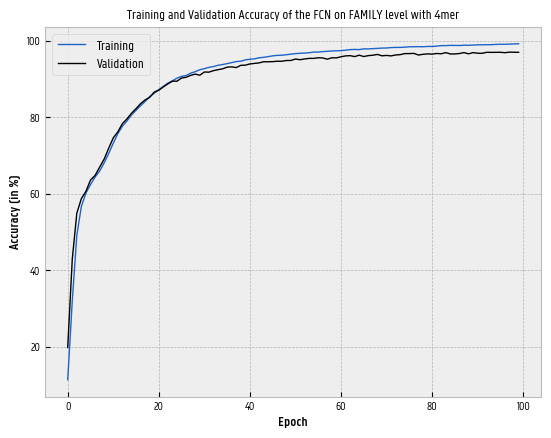

Training, validation and testing on FAMILY level with 4mer is completed.


In [ ]:
FCNK('4mer', 'FAMILY', 100)

Initiating training, validation and testing on GENUS level with 4mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 4.4372, Training Accuracy: 9.89%
Epoch [1] Validation Loss: 3.8100, Validation Accuracy: 15.48%
Epoch [2] Training Loss: 3.2093, Training Accuracy: 28.92%
Epoch [2] Validation Loss: 2.5383, Validation Accuracy: 39.44%
Epoch [3] Training Loss: 2.2337, Training Accuracy: 44.09%
Epoch [3] Validation Loss: 2.0163, Validation Accuracy: 48.07%
Epoch [4] Training Loss: 1.9158, Training Accuracy: 48.95%
Epoch [4] Validation Loss: 1.8312, Validation Accuracy: 50.83%
Epoch [5] Training Loss: 1.7704, Training Accuracy: 51.93%
Epoch [5] Validation Loss: 1.7258, Validation Accuracy: 52.24%
Epoch [6] Training Loss: 1.6684, Training Accuracy: 54.19%
Epoch [6] Validation Loss: 1.6327, Validation Accuracy: 55.47%
Epoch [7] Training Loss: 1.5601, Training Accu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.982     0.982     0.982        56
           1      0.867     0.867     0.867        15
           2      1.000     0.929     0.963        42
           3      0.962     1.000     0.981        76
           4      0.938     1.000     0.968        15
           5      0.935     0.935     0.935        31
           6      0.941     0.948     0.945       135
           7      0.929     0.929     0.929        14
           8      0.889     0.842     0.865        19
           9      0.821     0.958     0.885        24
          10      1.000     0.867     0.929        15
          11      0.976     1.000     0.988        40
          12      0.867     0.765     0.812        17
          13      0.783     0.947     0.857        19
          14      0.941     1.000     0.970        32
          15      0.962     0.969     0.966       130
          16      0.600     0.857     0.706         7
          17      1.000    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

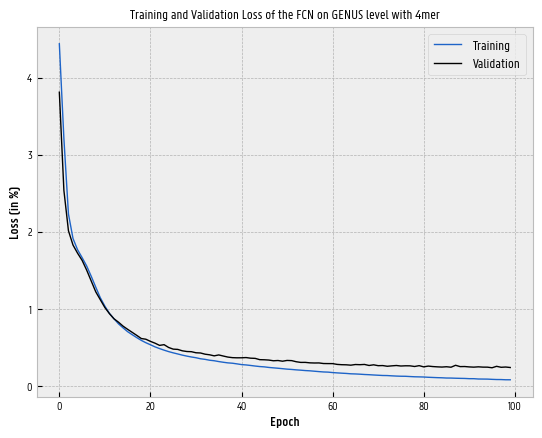

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

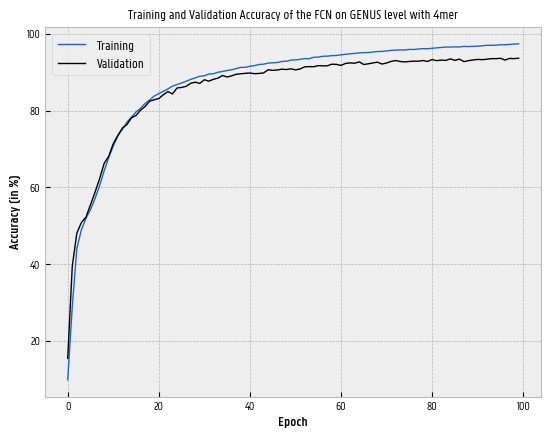

Training, validation and testing on GENUS level with 4mer is completed.


In [ ]:
FCNK('4mer', 'GENUS', 100)

# 5mer

Initiating training, validation and testing on PHYLUM level with 5mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 0.2281, Training Accuracy: 91.41%
Epoch [1] Validation Loss: 0.0097, Validation Accuracy: 99.88%
Epoch [2] Training Loss: 0.0052, Training Accuracy: 99.94%
Epoch [2] Validation Loss: 0.0028, Validation Accuracy: 99.96%
Epoch [3] Training Loss: 0.0016, Training Accuracy: 99.98%
Epoch [3] Validation Loss: 0.0020, Validation Accuracy: 99.97%
Epoch [4] Training Loss: 0.0011, Training Accuracy: 99.97%
Epoch [4] Validation Loss: 0.0018, Validation Accuracy: 99.98%
Epoch [5] Training Loss: 0.0006, Training Accuracy: 99.99%
Epoch [5] Validation Loss: 0.0019, Validation Accuracy: 99.98%
Epoch [6] Training Loss: 0.0002, Training Accuracy: 99.99%
Epoch [6] Validation Loss: 0.0034, Validation Accuracy: 99.91%
Epoch [7] Training Loss: 0.0006, Training Ac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

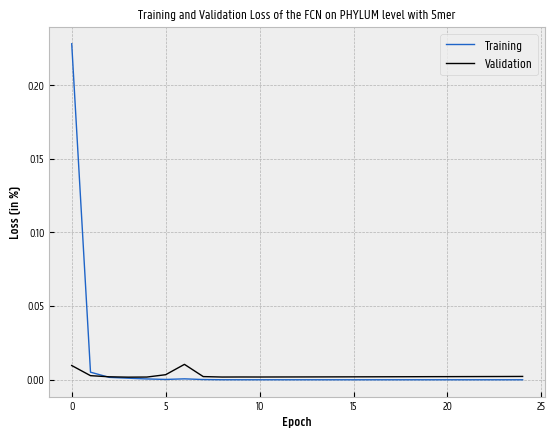

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

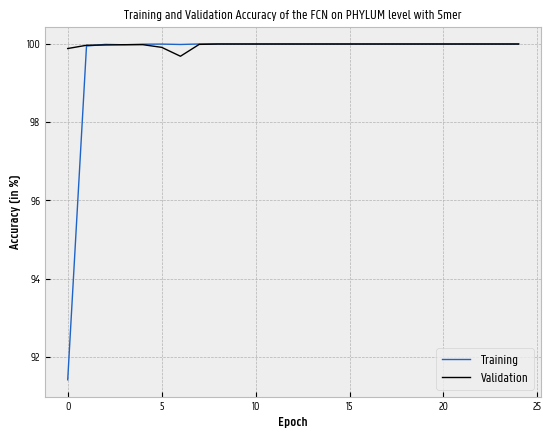

Training, validation and testing on PHYLUM level with 5mer is completed.


In [ ]:
FCNK('5mer', 'PHYLUM', 25)

Initiating training, validation and testing on CLASS level with 5mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 0.8760, Training Accuracy: 74.53%
Epoch [1] Validation Loss: 0.2692, Validation Accuracy: 92.29%
Epoch [2] Training Loss: 0.1627, Training Accuracy: 95.44%
Epoch [2] Validation Loss: 0.1162, Validation Accuracy: 97.23%
Epoch [3] Training Loss: 0.0668, Training Accuracy: 98.40%
Epoch [3] Validation Loss: 0.0626, Validation Accuracy: 98.43%
Epoch [4] Training Loss: 0.0331, Training Accuracy: 99.27%
Epoch [4] Validation Loss: 0.0477, Validation Accuracy: 98.97%
Epoch [5] Training Loss: 0.0201, Training Accuracy: 99.65%
Epoch [5] Validation Loss: 0.0319, Validation Accuracy: 99.39%
Epoch [6] Training Loss: 0.0132, Training Accuracy: 99.81%
Epoch [6] Validation Loss: 0.0301, Validation Accuracy: 99.41%
Epoch [7] Training Loss: 0.0093, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

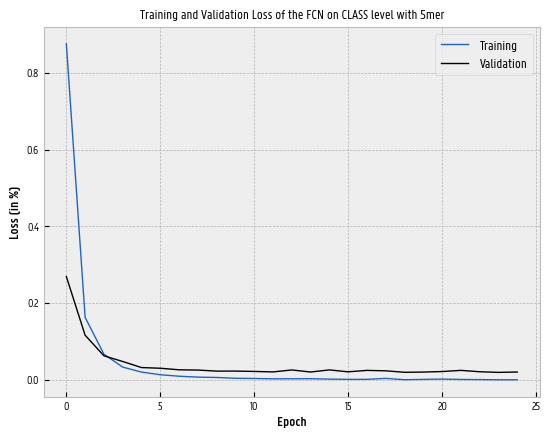

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

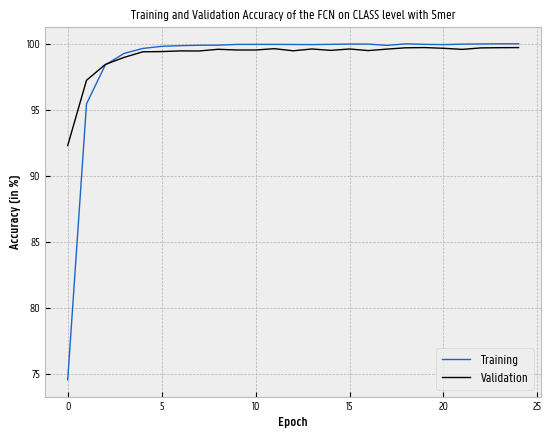

Training, validation and testing on CLASS level with 5mer is completed.


In [ ]:
FCNK('5mer', 'CLASS', 25)

Initiating training, validation and testing on ORDER level with 5mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 1.7619, Training Accuracy: 54.07%
Epoch [1] Validation Loss: 0.6349, Validation Accuracy: 82.73%
Epoch [2] Training Loss: 0.4220, Training Accuracy: 88.42%
Epoch [2] Validation Loss: 0.2999, Validation Accuracy: 92.11%
Epoch [3] Training Loss: 0.1939, Training Accuracy: 94.90%
Epoch [3] Validation Loss: 0.1600, Validation Accuracy: 96.06%
Epoch [4] Training Loss: 0.1036, Training Accuracy: 97.46%
Epoch [4] Validation Loss: 0.1149, Validation Accuracy: 97.26%
Epoch [5] Training Loss: 0.0688, Training Accuracy: 98.41%
Epoch [5] Validation Loss: 0.0959, Validation Accuracy: 97.87%
Epoch [6] Training Loss: 0.0491, Training Accuracy: 98.89%
Epoch [6] Validation Loss: 0.0805, Validation Accuracy: 98.26%
Epoch [7] Training Loss: 0.0363, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

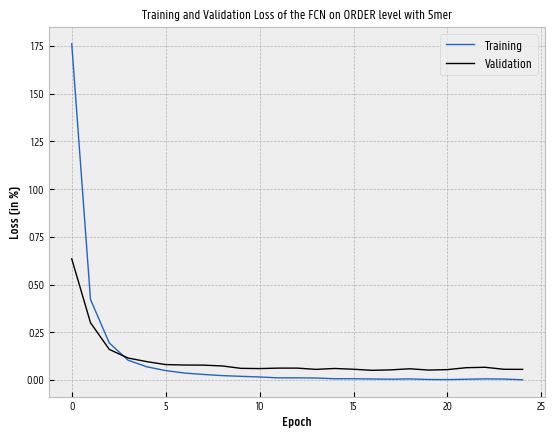

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

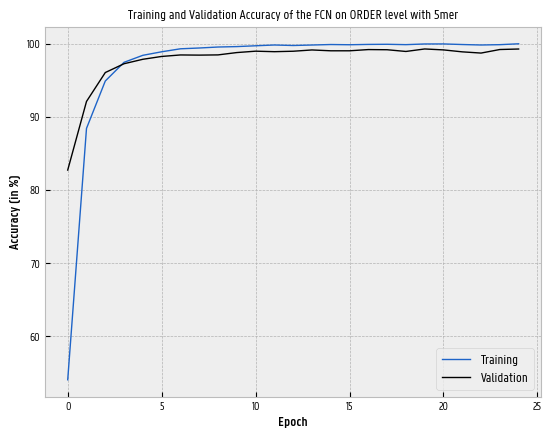

Training, validation and testing on ORDER level with 5mer is completed.


In [ ]:
FCNK('5mer', 'ORDER', 25)

Epoch [25] Validation Loss: 0.1058, Validation Accuracy: 97.88%
              precision    recall  f1-score   support

           0      1.000     0.933     0.966        15
           1      1.000     1.000     1.000        42
           2      0.993     0.987     0.990       298
           3      0.977     0.963     0.970       135
           4      1.000     1.000     1.000        14
           5      0.976     1.000     0.988        40
           6      0.941     1.000     0.970        32
           7      0.996     0.996     0.996       531
           8      1.000     0.933     0.966        15
           9      1.000     1.000     1.000        18
          10      0.938     0.833     0.882        18
          11      0.923     1.000     0.960        12
          12      0.959     0.922     0.940        51
          13      0.929     1.000     0.963        13
          14      0.905     0.950     0.927        20
          15      1.000     1.000     1.000        40
          16     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

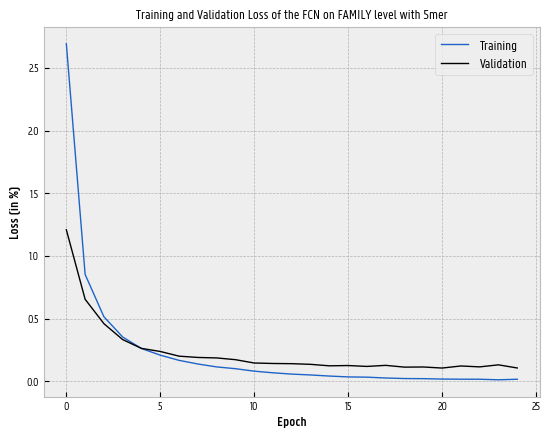

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

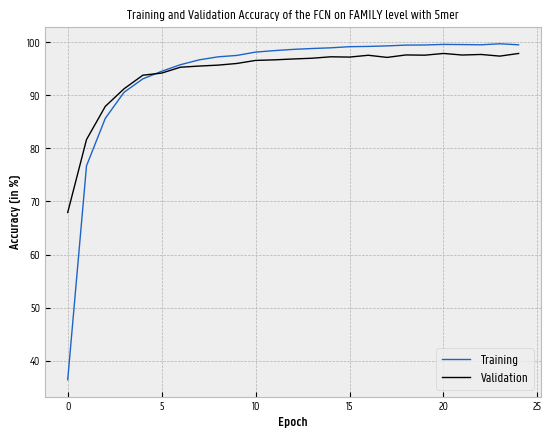

Training, validation and testing on FAMILY level with 5mer is completed.


In [ ]:
FCNK('5mer', 'FAMILY', 25)

In [ ]:
FCNK('5mer', 'GENUS', 25)

Initiating training, validation and testing on GENUS level with 5mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
